<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/Dynamic_FIA_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages

In [ ]:
!pip install mapclassify

## Import libraries

In [ ]:
import sqlite3, pandas as pd, numpy as np, gdown, zipfile, os, geopandas as gpd, folium

## Download FIA data for our study area (Indiana)

In [ ]:
url=r'https://apps.fs.usda.gov/fia/datamart/Databases/SQLite_FIADB_IN.zip'
out_zip_fl= 'fiadb.zip'

if(not os.path.exists(out_zip_fl)):
    gdown.download(url=url,output=out_zip_fl,quiet=False,fuzzy=True)
    with zipfile.ZipFile(out_zip_fl, 'r') as zip_ref:
        zip_ref.extractall(".")





## List all tables in the database

In [ ]:
def list_sqlite_tables(database_file):
    """
    Connects to an SQLite database and returns a list of table names.
    """
    try:
        conn = sqlite3.connect(database_file)
        cursor = conn.cursor()

        # Query the sqlite_master table for table names
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

        # Fetch all results
        tables = cursor.fetchall()

        # Extract table names from the list of tuples and filter out 'sqlite_sequence'
        table_names = [table[0] for table in tables if table[0] != 'sqlite_sequence']

        return table_names

    except sqlite3.Error as e:
        print(f"Error connecting to or querying the database: {e}")
        return []
    finally:
        if 'conn' in locals() and conn:
            conn.close()

# Usage example:
db_file = "SQLite_FIADB_IN.db"  # Replace with your database file name
tables = list_sqlite_tables(db_file)

if tables:
    print(f"Tables in '{db_file}':")
    for table_name in tables:
        print(f"- {table_name}")
else:
    print(f"No tables found in '{db_file}' or an error occurred.")

## Get the PLOT, PLOTGEOM, SUBPLOT, and TREE table records

In [ ]:
def get_tables(db_path,tbl_lst):
  '''
  Returns all records as a dataframe from specified tables as a list of dataframes

  db_path = (str) path to sqlight database
  tbl_lst = (list) table names as strings

  returns list of dataframes in the same order as specified tbl names

  '''
  conn=sqlite3.connect(db_path)
  cursor = conn.cursor()
  dbf_lst=[]
  for tbl in tbl_lst:
    sql="SELECT * FROM " + tbl
    dbf_lst.append(pd.read_sql(sql,conn))

  conn.close()
  return dbf_lst

plot,plotgeom,tree,subplot=get_tables('SQLite_FIADB_IN.db',['PLOT','PLOTGEOM','TREE','SUBPLOT'])

## Convert dataframes to geodataframes
- Notice the number of duplicated plot locations. Why are there duplicate plot locations?
- What combination of columns can be used to identify a unique plot?
- Can a plot be measured more than once in this database? Why?
- Are the plot latitudes and longitudes the real location of the plots?

In [ ]:
plot_df=gpd.GeoDataFrame(plot,geometry=gpd.GeoSeries.from_xy(plot.LON,plot.LAT,crs='EPSG:4326'))
print(plot_df.shape)
plot_df2=plot_df.drop_duplicates('geometry')
print(plot_df2.shape)


## Let's make a grid of locations across the study site.
- Spacing 10 km apart
- Why don't we want to use WGS 84 as our coordinate system?
- How can you convert WGS 84 to a projected coordinate system that has units in meters?
- Why does the spacing between location look further apart at the top of the map?

In [ ]:
dist=10000 #10km
xmin,ymin,xmax,ymax=plot_df.to_crs('ESRI:102005').total_bounds
rx,ry=np.random.randint(0,dist/2,2) #why a random start for x and y
xs=np.arange(xmin+rx,xmax,dist)
ys=np.arange(ymin+ry,ymax,dist)
xs2,ys2=np.meshgrid(xs,ys)
grid_loc=gpd.GeoSeries.from_xy(xs2.ravel(),ys2.ravel(),crs='ESRI:102005')

#### Create an interactive map of locations and FIA fuzzed plots

In [ ]:
m=plot_df2.explore(color='lightgreen',name='FIA plot')
m=grid_loc.explore(color='red',m=m, name='Grid point location')
display(m)

### Summarizing basal area for each plot
- summarize the tree table to the plot
- merge the summarized tree table to the plot table
- aggregate the plot estimates to the grid cell

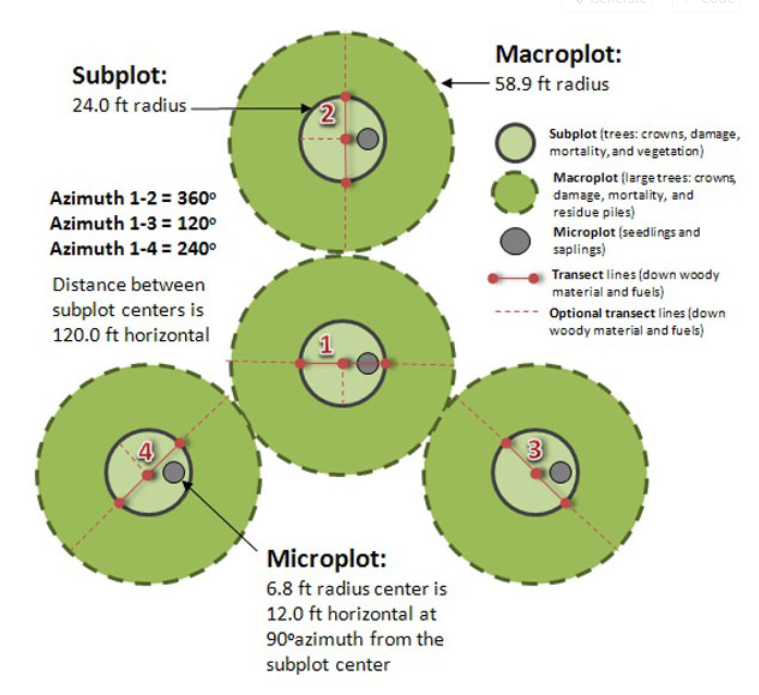

In [ ]:
ex_fact=43560/(4*np.pi*24**2) #per acre estimate based on 4 subplot areas
tree['BAA']=(0.005454*tree.DIA**2)*ex_fact #calculate basal area of each tree (square feet)
s_tree=tree[['CN', 'PLT_CN', 'PREV_TRE_CN', 'INVYR', 'PLOT', 'SUBP', 'TREE', 'STATUSCD', 'SPCD', 'SPGRPCD', 'DIA', 'HT', 'CR', 'TREEGRCD','BAA']] #subset the columns
s_tree=s_tree[s_tree.STATUSCD==1] #get only live trees
plt_baa_sum=s_tree.groupby(['PLT_CN']).BAA.sum() #group the data and sum BAA


### Merge BAA estimates with the plot

In [ ]:
plot_baa=plot_df.merge(plt_baa_sum,how='left',left_on='CN',right_on='PLT_CN')
plot_baa.BAA=plot_baa.BAA.fillna(0)

### Filter out previously measured plots and select plots that have been measured within the last 10 years

In [ ]:
tdf1=plot_baa[~plot_baa.CN.isin(plot_baa.PREV_PLT_CN)] #get the most current plot (remove any plots where the CN number is in the previous CN number)
plot_baa_gte_2014=tdf1[tdf1.MEASYEAR>=2014] #select only plots that have been measured in the last 10 years (remember the database in 2024)

## Variable radius plot selection
### Split the FIA plots measured after 2014 into forested and nonforested dataframes using BAA estimates

In [ ]:
plt_trees=plot_baa_gte_2014[plot_baa_gte_2014.BAA>0] #plots with trees (BAA)
plt_no_trees=plot_baa_gte_2014[plot_baa_gte_2014.BAA<=0] #plots without trees (BAA)

#convert geodataframes from geometries to numpy coordinates for KD tree function
tree_coords=(plt_trees.to_crs(grid_loc.crs)).geometry.get_coordinates().values #project to coordinate system
no_tree_coords=(plt_no_trees.to_crs(grid_loc.crs)).geometry.get_coordinates().values #project to coordinate system
grid_coords=grid_loc.geometry.get_coordinates().values


### Get at least 50 plots with trees and without trees and find the maximum distance for buffering
- Note, I am using BAA as the threshold. However, some plots may not have been measured for various reasons. You may want to use different logic to determine plot labels.

#### Use Scipy Spatial to create a KDTree and determine buffer distance for each grid location. Specify buffer distance as the maximum distance need to get at least 50 forest and nonforest points.

In [ ]:
from scipy.spatial import KDTree
nn=51 #number of neighbors + 1
_tree=KDTree(tree_coords) #using Euclidean distance by default
ntree=KDTree(no_tree_coords)

tdist,tind=_tree.query(grid_coords,nn)
ndist,nind=ntree.query(grid_coords,nn)

mtdist=tdist[:,-1]
mndist=ndist[:,-1]

grid=gpd.GeoDataFrame(geometry=grid_loc)

#Get the max distance of the 50 forest and nonforest plots
ch=mtdist<mndist
grid.loc[ch,'buff_dist']=mndist[ch]
ch=mtdist>=mndist
grid.loc[ch,'buff_dist']=mtdist[ch]



### Get training sets for each grid point and buffer.
- Note, you could also build models here and store the model as an object in a database
- Likewise, a similar function could be built to produce a mode for any location/polygon supplied
- How many observations do you have for each grid_point?
- How many forested and nonfoested observatioins do you have for each training set?
- Do you have enought points to create a machine learning model for BAA?

In [ ]:
t=plot_baa_gte_2014.to_crs(grid.crs)
train_lst=[]
nf_lst=[]
f_lst=[]
n_lst=[]
for r in grid.itertuples():
    geo=r.geometry
    dist=r.buff_dist
    buff=geo.buffer(dist)
    t2=t.clip(buff)
    f_lst.append((t2.BAA>0).sum())
    nf_lst.append((t2.BAA<0.001).sum())
    n_lst.append(t2.shape[0])
    train_lst.append(t2)

grid['n_plots']=n_lst
grid['f_plots']=f_lst
grid['nf_plots']=nf_lst
grid

### Look at the mean and standard deviation estimates. Note, we have the potential to do a lot more with modeling.


In [ ]:
grid_cell_baa_m = []
grid_cell_baa_s = []
for train in train_lst:
    grid_cell_baa_m.append(train.BAA.mean())
    grid_cell_baa_s.append(train.BAA.std())

tdf=pd.DataFrame({'v_mean':grid_cell_baa_m,'v_std':grid_cell_baa_s})
s_grid=grid.merge(tdf,left_index=True,right_index=True)
display(s_grid.hist(['v_mean','v_std'],figsize=(15,4),density=True))
# c_gdf_baa=gdf_baa.merge(s_grid,left_index=True,right_index=True)
# c_gdf_baa
# display(c_gdf_baa.hist(['mean','v_mean','std','v_std'],sharey=True,sharex=True,figsize=(15,15),density=True)) #plot the distributions
# c_gdf_baa.set_geometry('geometry_x').explore(column='v_mean') #map the v_mean values

In [ ]:
#create a map of mean and sd estimates
m=s_grid.explore(column='v_mean',name='Mean') #show the spatial location of mean BAA
m=s_grid.explore(column='v_std', m=m, name='Standard Deviation')
folium.LayerControl().add_to(m)
m

### Modeling BAA
At this piont we have created a very simple intercept only model (mean value). As we can see from our standard deviation map ($\sqrt{variance}$ we have substantial variation assocaited with each gridded location. To reduce our estimation error ($\sqrt{variance} in this case) we can use ancillary data that has some type of relationship with BA. So what ancillary data are we going to use and how are we going to get it for each of our training sets? For this example we will use Google Earth Engine and the fuzzed coordinate locations to extract Basal area estimates (response) and satelite embeddings.